# Explain Electricity Prices

In [36]:
!pip install -q pycaret

In [37]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import xgboost as xgb
import lightgbm as lgbm

from scipy import stats


In [38]:
X = pd.read_csv("X_train.csv", index_col="ID")
y = pd.read_csv("y_train.csv", index_col="ID")
data = X.copy()
data = data.join(y, on="ID").reset_index()

In [39]:
data.head(n=3)

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,-0.692860,0.441238,-0.213766,0.740627,0.288782,2.209047,0.207838,0.709614,-0.190463,0.101766,1.248911,-0.573370,-0.269460,0.870344,0.626666,-0.444661,-0.17268,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,-0.170392,-0.762153,0.187964,-0.807112,-1.882740,-2.185961,1.987428,3.237380,-0.035514,-0.107350,-0.194308,-0.395469,-1.183194,-1.24030,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,1.572267,0.777053,-0.108578,0.779142,-1.897109,0.735137,-1.115583,-0.371039,-0.298755,-0.141239,0.428272,1.336625,1.947273,-0.48070,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840


## EDA

### Number of samples per country

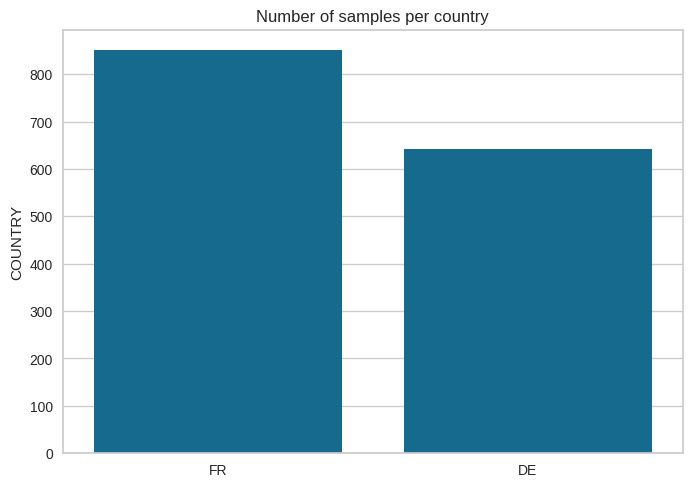

In [40]:
fig, ax = plt.subplots()
sns.barplot(data["COUNTRY"].value_counts())
ax.set_title("Number of samples per country")
plt.show()


### Missing Values

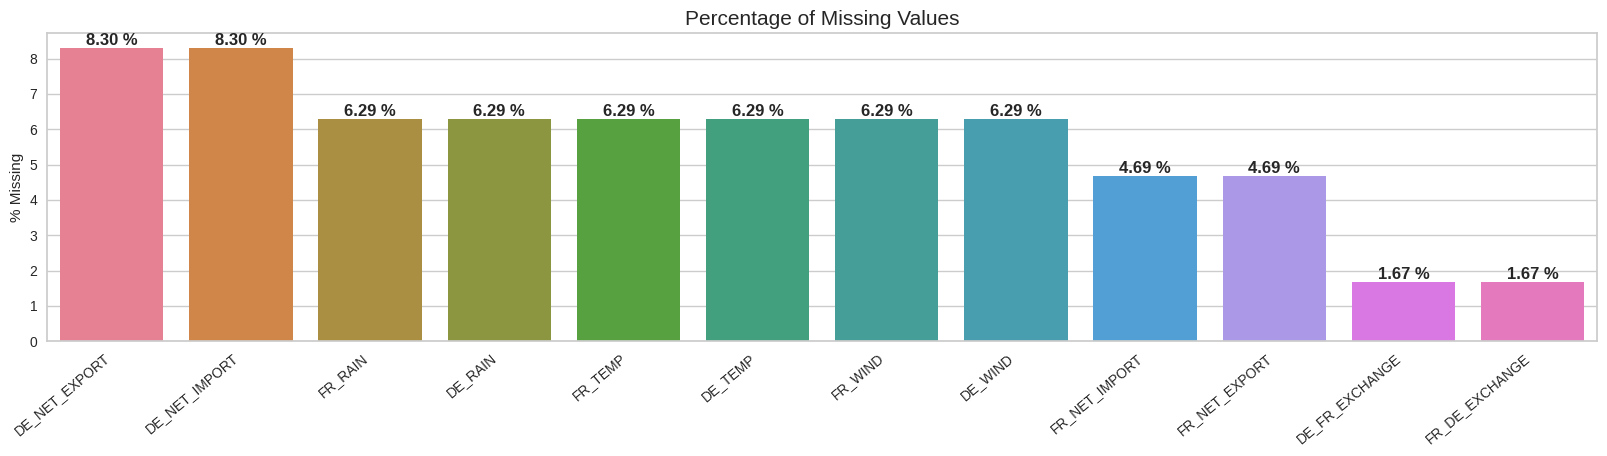

In [41]:
fig, ax = plt.subplots(figsize=(20, 4))
ax = sns.barplot(
    (
        data.isna()
        .sum(axis=0)/len(data)*100
    )
    .sort_values(ascending=False)
    .to_frame(name='% missing')
    .iloc[:12, :].T,
    ax=ax,
)
for container in ax.containers:
    ax.bar_label(container, fmt="{:,.2f} %", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Percentage of Missing Values", size=15)
ax.set_ylabel("% Missing")
plt.show()

In [42]:
data = (
    data
    .interpolate(method='polynomial',order=3)
    .fillna(0)
)

### Pairwise Spearman rank correlation of columns

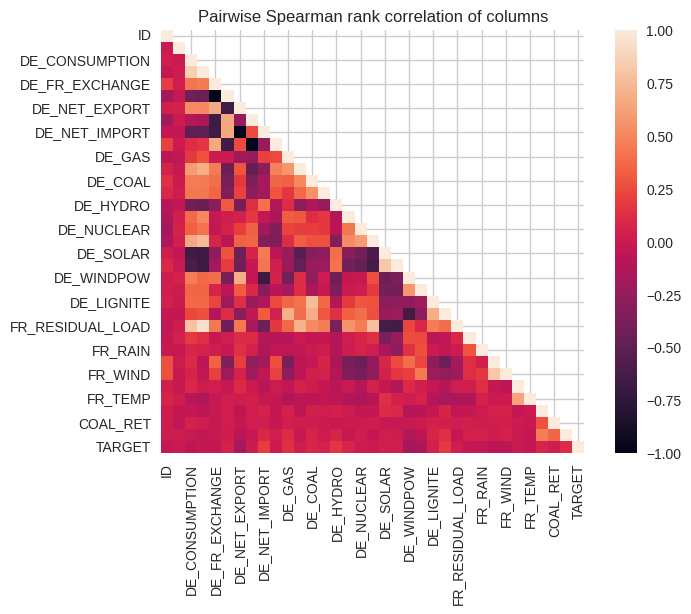

In [43]:
correlations = data.corr(method="spearman")
mask = np.triu(np.ones_like(correlations, dtype=bool), 1)

fig, ax = plt.subplots()
sns.heatmap(correlations, square=True, mask=mask, ax=ax)
ax.set_title("Pairwise Spearman rank correlation of columns")
plt.show()

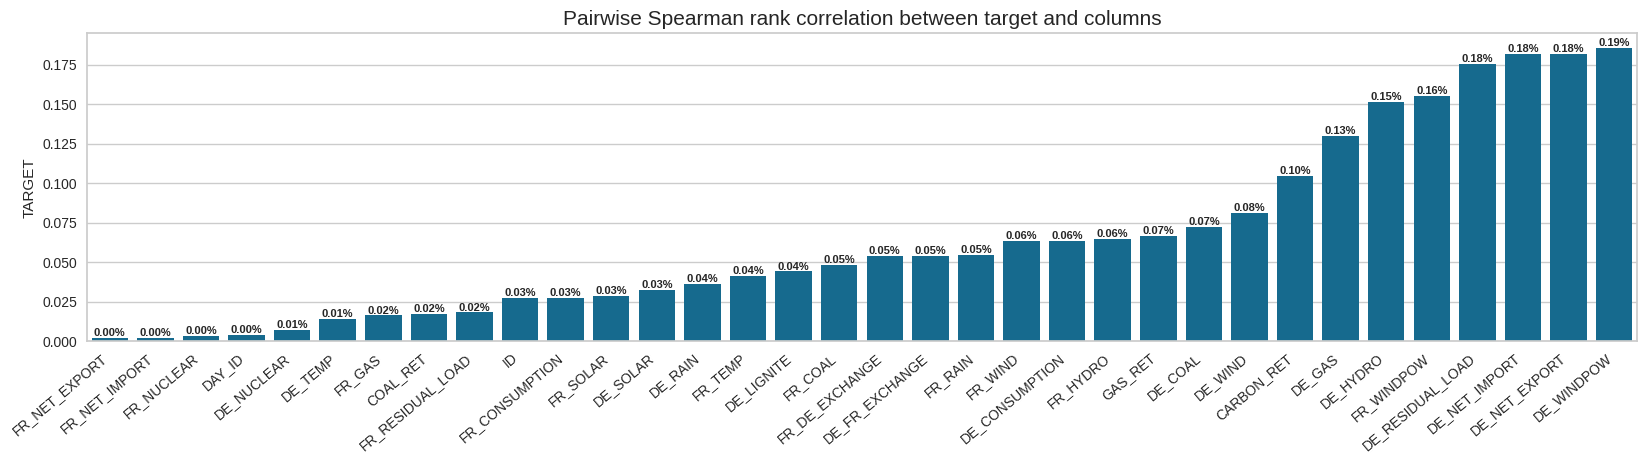

In [44]:
fig, ax = plt.subplots(figsize=(20, 4))

corr_df = (
    pd.DataFrame(correlations["TARGET"])
    .abs()
    .sort_values(by="TARGET", ascending=True)
    .drop(index=["TARGET"])
    ["TARGET"]
)
sns.barplot(corr_df)

for container in ax.containers:
    ax.bar_label(container, fmt="{:,.2f}%", fontsize=8, weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Pairwise Spearman rank correlation between target and columns", size=15)
plt.show()


In [45]:
drop_columns = corr_df.loc[corr_df < 0.05].index.tolist()
drop_columns.remove("DAY_ID")
data.drop(columns=drop_columns, inplace=True)

### Distribution of columns per country

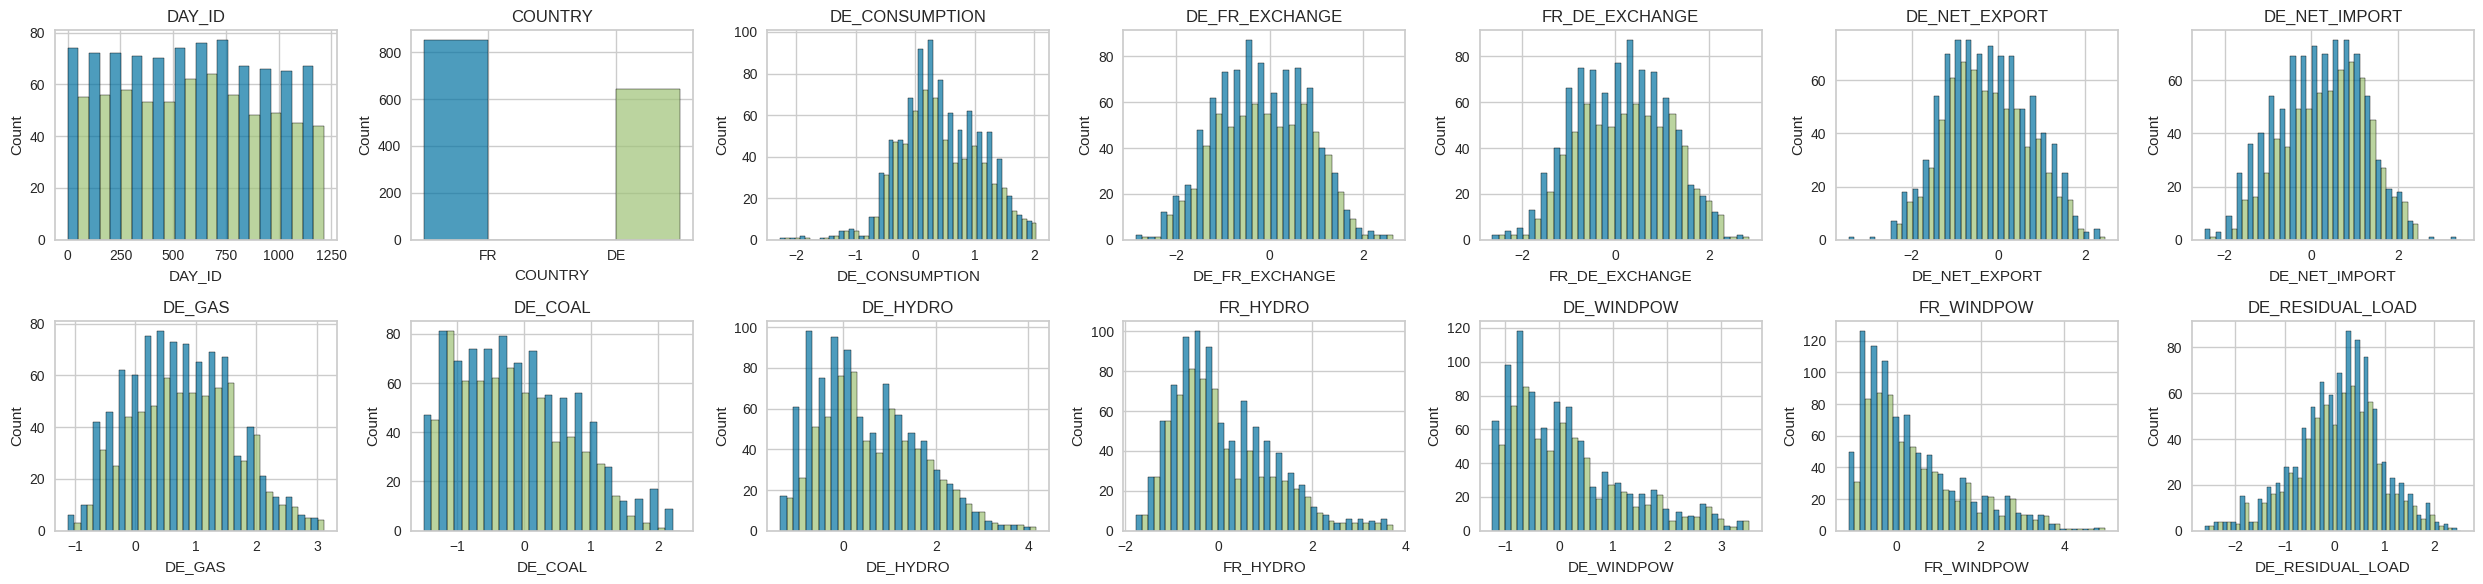

In [46]:
num_columns = 7
num_rows = len(data.columns) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 6))
axes = axes.flatten()

for i, (ax, column) in enumerate(zip(axes, data.columns)):
    ax.set_title(column)
    sns.histplot(
        ax=ax,
        data=data,
        x=column,
        hue="COUNTRY",
        multiple="dodge",
        alpha=0.7
    )
    ax.get_legend().remove()

    # to remove the extra empty plots
    if not ax.has_data():
        fig.delaxes(ax)

fig.tight_layout()
plt.show()

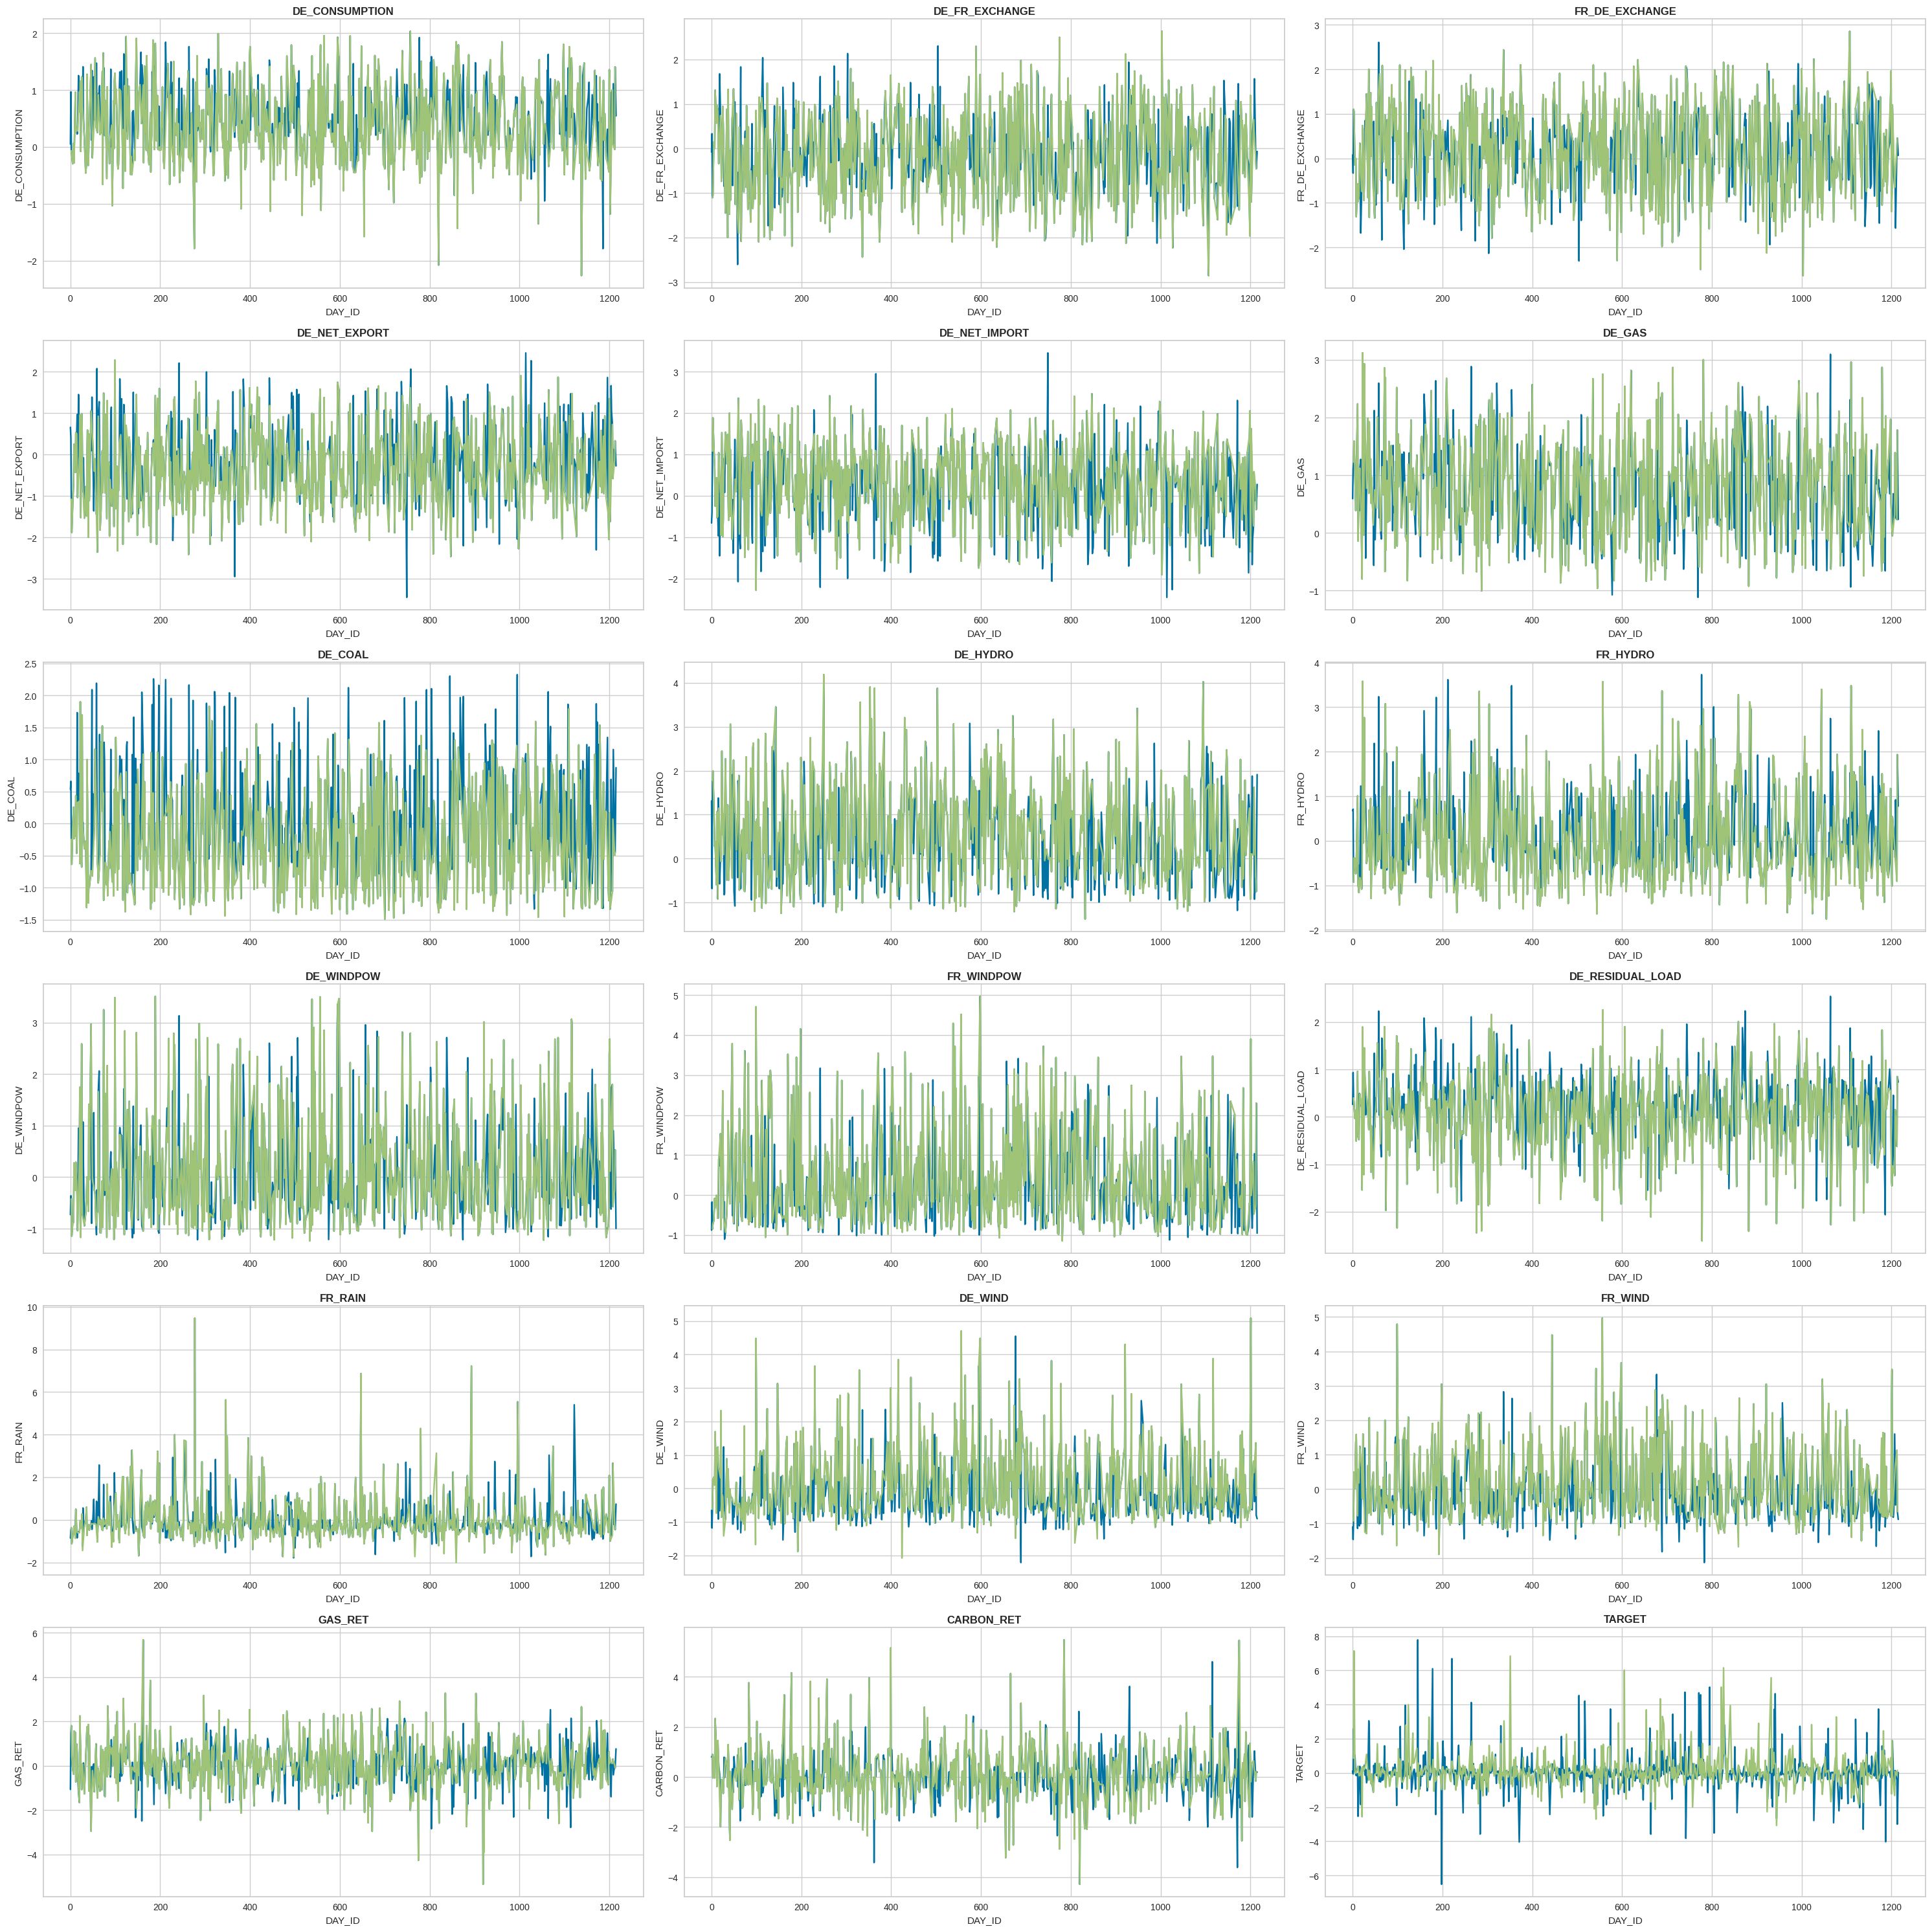

In [47]:
columns = data.columns.tolist()
columns.remove("DAY_ID")
columns.remove("COUNTRY")

num_columns = 3
num_rows = len(columns) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(30, 30))
axes = axes.flatten()

for i, (ax, column) in enumerate(zip(axes, columns)):
    ax.set_title(column, weight="bold")
    sns.lineplot(
        ax=ax,
        data=data,
        x="DAY_ID",
        y=column,
        hue="COUNTRY",
    )
    ax.get_legend().remove()

    # to remove the extra empty plots
    if not ax.has_data():
        fig.delaxes(ax)

fig.tight_layout()
plt.show()

## Modelling

In [48]:
data["COUNTRY"] = pd.get_dummies(data["COUNTRY"]).drop(columns=["FR"]).rename({"DE": "COUNTRY"}, axis=1)
data.sort_values(by="DAY_ID", inplace=True)

In [49]:
def spearman_correlation(y, y_pred, **kwargs):
    out = stats.spearmanr(y, y_pred)
    return out.correlation

In [50]:
def cross_validation_time_series(Xy, estimator, n_splits):
    scores = []
    cv = TimeSeriesSplit(n_splits=n_splits)
    for fold_id, (train_indices, test_indices) in enumerate(cv.split(Xy)):
        train, test = Xy.loc[train_indices], Xy.loc[test_indices]

        estimator.fit(X=train.drop(columns=["TARGET"]), y=train["TARGET"])

        y_pred = estimator.predict(test.drop(columns=["TARGET"]))

        s = spearman_correlation(test["TARGET"], y_pred)
        scores.append(s)

        print(f"Fold [{fold_id}/{n_splits}]: Spearman rank correlation: {s:.3f}")

    mean, std = np.mean(scores), np.std(scores)
    print(f"Mean: {mean:.3f} - Std: {std:.3f}")
    return mean, std, estimator


In [51]:
def random_grid_search_cross_validation_time_series(Xy, estimator, param_grid, n_splits):
    cv = TimeSeriesSplit(n_splits=n_splits)

    gs = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_grid,
        cv=cv,
        n_jobs=-1,
        verbose=True,
        scoring=make_scorer(spearman_correlation, greater_is_better=True),
    )
    if not isinstance(estimator, lgbm.LGBMRegressor):
        gs.fit(X=Xy.drop(columns=["TARGET"]), y=Xy["TARGET"])
    else:
        # remove verbosity for lightgbm
        callbacks = [lgbm.log_evaluation(period=0)]
        gs.fit(X=Xy.drop(columns=["TARGET"]), y=Xy["TARGET"], callbacks=callbacks)
    return gs


### Decision Tree

In [52]:
estimator = DecisionTreeRegressor()
mean, sigma, estimator = cross_validation_time_series(data.copy(), estimator, 4)


Fold [0/4]: Spearman rank correlation: 0.034
Fold [1/4]: Spearman rank correlation: 0.018
Fold [2/4]: Spearman rank correlation: 0.143
Fold [3/4]: Spearman rank correlation: 0.056
Mean: 0.063 - Std: 0.048


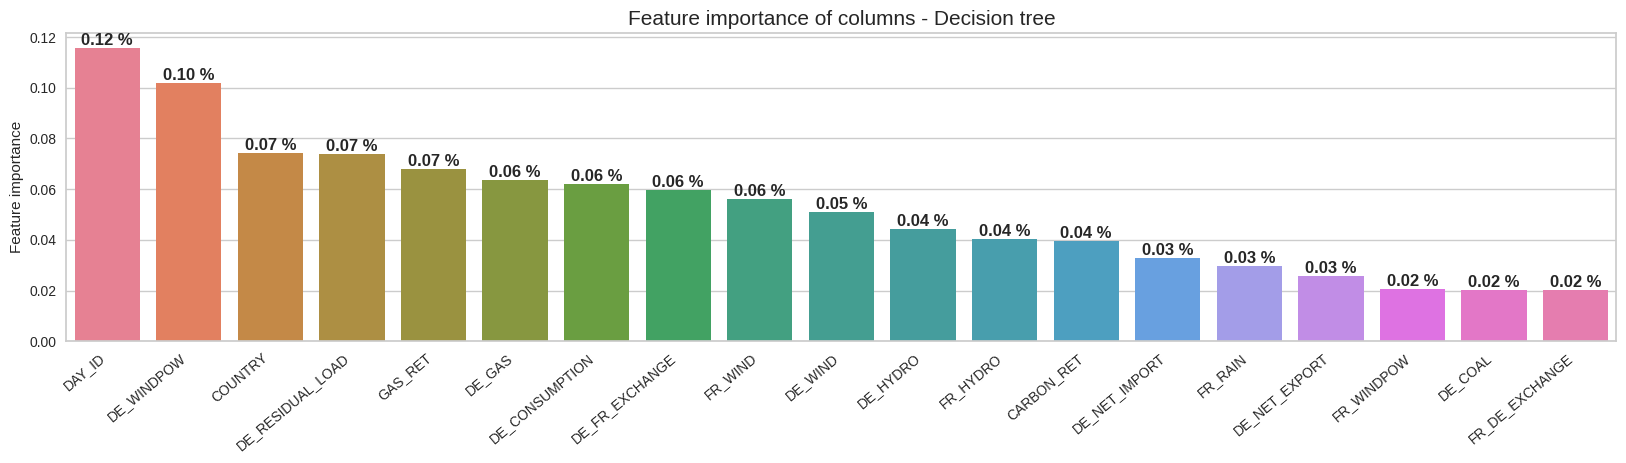

In [53]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(
    data=(
        pd.DataFrame(
            estimator.feature_importances_.reshape(1, -1),
            columns=estimator.feature_names_in_,
            index=["feature_importance"]
        )
        .T
        .sort_values(by="feature_importance", ascending=False)
        .T
    ),
    ax=ax
)

ax.set_title("Feature importance of columns - Decision tree", size=15)
ax.set_ylabel("Feature importance")
for container in ax.containers:
    ax.bar_label(container, fmt="{:,.2f} %", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

#### Grid search

In [54]:
estimator = DecisionTreeRegressor()

param_grid = {
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

results = random_grid_search_cross_validation_time_series(
    data.copy(),
    estimator=estimator,
    param_grid=param_grid,
    n_splits=4
)
print("Spearman rank correlation:", results.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Spearman rank correlation: 0.10276457627604213


### Random Forests

In [55]:
estimator = RandomForestRegressor()
mean, sigma, estimator = cross_validation_time_series(data.copy(), estimator, 4)


Fold [0/4]: Spearman rank correlation: 0.167
Fold [1/4]: Spearman rank correlation: 0.178
Fold [2/4]: Spearman rank correlation: 0.199
Fold [3/4]: Spearman rank correlation: 0.097
Mean: 0.160 - Std: 0.038


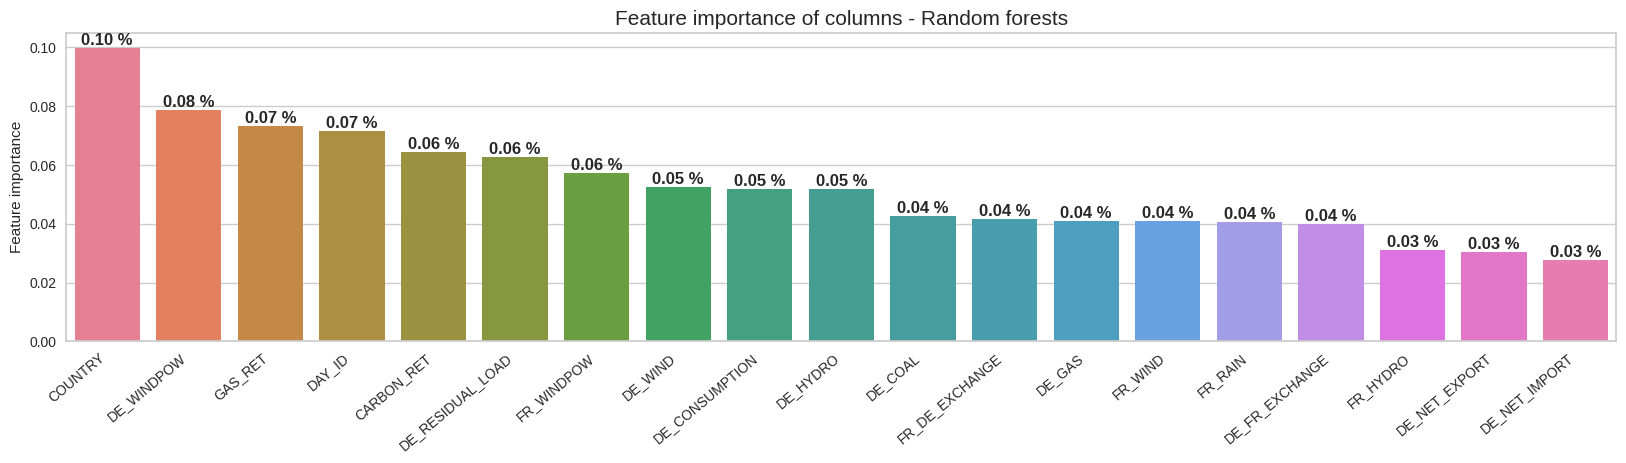

In [56]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(
    data=(
        pd.DataFrame(
            estimator.feature_importances_.reshape(1, -1),
            columns=estimator.feature_names_in_,
            index=["feature_importance"]
        )
        .T
        .sort_values(by="feature_importance", ascending=False)
        .T
    ),
    ax=ax
)

ax.set_title("Feature importance of columns - Random forests", size=15)
ax.set_ylabel("Feature importance")
for container in ax.containers:
    ax.bar_label(container, fmt="{:,.2f} %", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

#### Grid search

In [57]:
estimator = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

results = random_grid_search_cross_validation_time_series(
    data.copy(),
    estimator=estimator,
    param_grid=param_grid,
    n_splits=4
)
print("Spearman rank correlation:", results.best_score_)


Fitting 4 folds for each of 10 candidates, totalling 40 fits
Spearman rank correlation: 0.18409924072817369


### XGBoost

In [58]:
estimator = xgb.XGBRFRegressor()
mean, sigma, estimator = cross_validation_time_series(data.copy(), estimator, 4)


Fold [0/4]: Spearman rank correlation: 0.218
Fold [1/4]: Spearman rank correlation: 0.175
Fold [2/4]: Spearman rank correlation: 0.176
Fold [3/4]: Spearman rank correlation: 0.117
Mean: 0.171 - Std: 0.036


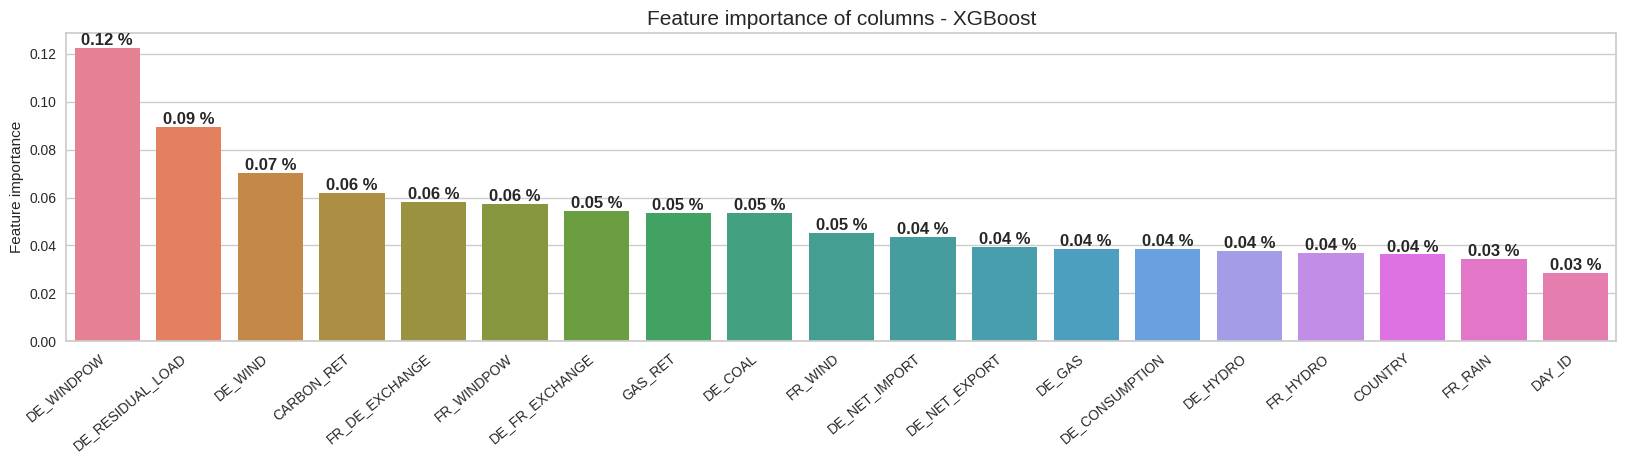

In [59]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(
    data=(
        pd.DataFrame(
            estimator.feature_importances_.reshape(1, -1),
            columns=estimator.feature_names_in_,
            index=["feature_importance"]
        )
        .T
        .sort_values(by="feature_importance", ascending=False)
        .T
    ),
    ax=ax
)

ax.set_title("Feature importance of columns - XGBoost", size=15)
ax.set_ylabel("Feature importance")
for container in ax.containers:
    ax.bar_label(container, fmt="{:,.2f} %", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

#### Grid search

In [60]:
estimator = lgbm.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    metric='mse'
)

param_grid = {
    'num_leaves': [15, 31, 50],
    'learning_rate': [0.05, 0.1, 0.2],
    'feature_fraction': [0.6, 0.8, 0.9],
    'bagging_fraction': [0.6, 0.8, 0.9],
    'bagging_freq': [3, 5, 7]
}

results = random_grid_search_cross_validation_time_series(
    data.copy(),
    estimator=estimator,
    param_grid=param_grid,
    n_splits=4
)
print("Spearman rank correlation:", results.best_score_)


Fitting 4 folds for each of 10 candidates, totalling 40 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in th

### LightGBM

In [ ]:
estimator = lgbm.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    metric='mse'
)

mean, sigma, estimator = cross_validation_time_series(data.copy(), estimator, 4)


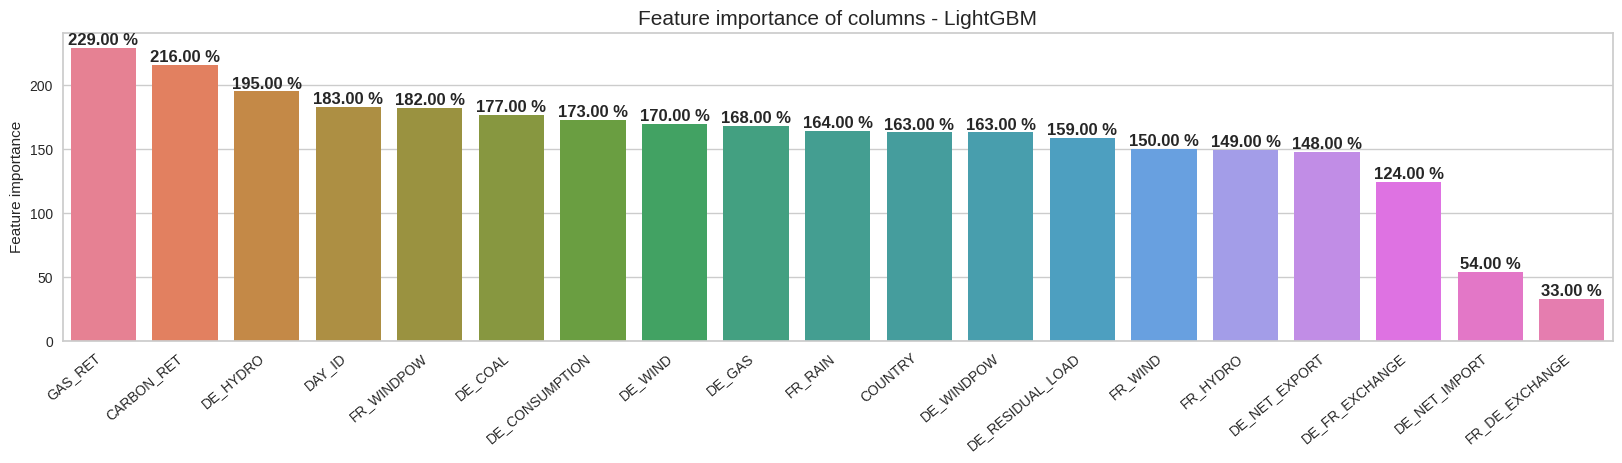

In [62]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(
    data=(
        pd.DataFrame(
            estimator.feature_importances_.reshape(1, -1),
            columns=estimator.booster_.feature_name(),
            index=["feature_importance"]
        )
        .T
        .sort_values(by="feature_importance", ascending=False)
        .T
    ),
    ax=ax
)

ax.set_title("Feature importance of columns - LightGBM", size=15)
ax.set_ylabel("Feature importance")
for container in ax.containers:
    ax.bar_label(container, fmt="{:,.2f} %", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

#### Grid search

In [ ]:
estimator = lgbm.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    metric='mse'
)

param_grid = {
    'num_leaves': [15, 31, 50],
    'learning_rate': [0.05, 0.1, 0.2],
    'feature_fraction': [0.6, 0.8, 0.9],
    'bagging_fraction': [0.6, 0.8, 0.9],
    'bagging_freq': [3, 5, 7]
}

results = random_grid_search_cross_validation_time_series(
    data.copy(),
    estimator=estimator,
    param_grid=param_grid,
    n_splits=4
)
print("Spearman rank correlation:", results.best_score_)



## AutoML with Pycaret

In [64]:
from pycaret.regression import setup


### Without pre-processing

In [65]:
exp = setup(
    data=data,
    target="TARGET",
    preprocess=False,
    data_split_shuffle=False,
    fold_strategy="timeseries",
)
exp.add_metric('spearman_correlation', 'spearman_correlation', spearman_correlation)

best = exp.compare_models(sort="spearman_correlation")

,Description,Value
0,Session id,1673
1,Target,TARGET
2,Target type,Regression
3,Original data shape,"(1494, 20)"
4,Transformed data shape,"(1494, 20)"
5,Transformed train set shape,"(1045, 20)"
6,Transformed test set shape,"(449, 20)"
7,Numeric features,19


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,spearman_correlation,TT (Sec)
ridge,Ridge Regression,0.6225,1.1692,1.0551,-0.0847,0.4252,4.7545,0.2350,0.0140
lr,Linear Regression,0.6295,1.1880,1.0616,-0.0991,0.4278,4.8382,0.2340,0.1460
lar,Least Angle Regression,0.7561,1.6111,1.1703,-0.4122,0.4554,5.8706,0.2281,0.0200
huber,Huber Regressor,0.5495,1.0740,1.0166,-0.0047,0.4354,2.4981,0.2246,0.0430
br,Bayesian Ridge,0.5654,1.0948,1.0266,-0.0269,0.4221,3.2061,0.2187,0.0160
ada,AdaBoost Regressor,0.7070,1.3096,1.1198,-0.2381,0.4466,5.7720,0.1660,0.1130
et,Extra Trees Regressor,0.6408,1.1955,1.0753,-0.1384,0.4281,5.5103,0.1590,0.4430
gbr,Gradient Boosting Regressor,0.6936,1.3297,1.1337,-0.2645,0.4466,6.5812,0.1504,0.2790
rf,Random Forest Regressor,0.6787,1.2763,1.1169,-0.2480,0.4350,7.0933,0.1351,1.0740
xgboost,Extreme Gradient Boosting,0.7340,1.4626,1.1701,-0.3463,0.4644,10.7884,0.1347,0.3320


Processing:   0%|          | 0/81 [00:00<?, ?it/s]